In [1]:
import os
import numpy as np
import torch
import mdtraj as md
import torch.nn as nn
import torch.nn.functional as F
import deeptime
from torch.utils.data import DataLoader
from tqdm import tqdm
# helpful neuron functions
# numpy arrays as inputs
def dif(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2))

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(12)


In [2]:
!find ~/Downloads $(pwd) -type f | grep enhanced

/Users/tommysisk/Downloads/enhanced_path_frames.pdb


In [3]:
traj = md.load("/Users/tommysisk/Downloads/enhanced_path_frames.pdb")
bb = traj.atom_slice(traj.topology.select("protein and backbone"))

In [4]:
#calculate contacts, create 3D array of 2D images
coords = bb.xyz 
tsr = np.empty([coords.shape[i] for i in [0,1,1]])
for n,i in enumerate(coords):
    for l,j in enumerate(np.flip(i,axis=0)):
        tsr[n][l] = np.array([dif(j,k) for k in i])

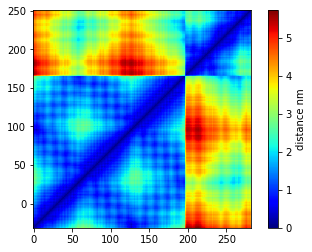

In [64]:
#plot an image
import matplotlib.pyplot as plt
plt.imshow(tsr[100],cmap="jet")
plt.colorbar(label="distance nm")
_=plt.yticks(np.arange(282)[::50],np.flip(np.arange(282)[::50]))

In [41]:
#process data
t1 = np.copy(tsr)
t1 = t1.reshape(643,1,282,282).astype(np.float32)
t1 = torch.from_numpy(t1)
t1 = t1/tsr.max()
dataset = deeptime.util.data.TrajectoryDataset(lagtime=30, trajectory=t1)
batch_size = 10
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [75]:
#create 2d convnets - either should work
#test by running random tensor through both
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,6)
        self.conv2 = nn.Conv2d(32,64,6)
        self.conv3 = nn.Conv2d(64,128,6)
        self.to_linear=None
        x = torch.randn(282,282).view(-1,1,282,282)
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,10)
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        if self.to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x.view(-1,self._to_linear)
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)

lobe2 = nn.Sequential(
    nn.Conv2d(1,32,6),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(32,64,6),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(64,128,6),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=(2,2)),
    nn.Flatten(),
    nn.Linear(115200 ,512),
    nn.ReLU(inplace=True),
    nn.Linear(512,2),
    nn.Softmax(dim=1)
)
    
    
r_ = 282
r = torch.rand((1,1,r_,r_))
lobe1 = Net()
print(lobe1(r))
print(lobe2(r))

        

tensor([[0.1029, 0.1014, 0.0974, 0.0960, 0.1020, 0.0958, 0.0972, 0.1058, 0.1031,
         0.0985]], grad_fn=<SoftmaxBackward0>)
tensor([[0.5003, 0.4997]], grad_fn=<SoftmaxBackward0>)


In [77]:
#run data through convnet to check 
lobe1(t1[::100])

tensor([[0.1038, 0.1015, 0.0983, 0.0969, 0.1004, 0.0971, 0.0970, 0.1039, 0.1026,
         0.0985],
        [0.1037, 0.1016, 0.0986, 0.0966, 0.1004, 0.0972, 0.0968, 0.1041, 0.1025,
         0.0984],
        [0.1037, 0.1015, 0.0986, 0.0968, 0.1004, 0.0972, 0.0968, 0.1041, 0.1026,
         0.0984],
        [0.1038, 0.1014, 0.0984, 0.0969, 0.1004, 0.0972, 0.0970, 0.1039, 0.1026,
         0.0985],
        [0.1038, 0.1015, 0.0982, 0.0970, 0.1004, 0.0971, 0.0970, 0.1039, 0.1026,
         0.0985],
        [0.1038, 0.1015, 0.0982, 0.0969, 0.1004, 0.0972, 0.0970, 0.1039, 0.1026,
         0.0985],
        [0.1038, 0.1014, 0.0982, 0.0970, 0.1004, 0.0972, 0.0970, 0.1039, 0.1026,
         0.0984]], grad_fn=<SoftmaxBackward0>)

In [78]:
#Create VAMP model, train,etc
lobe = lobe1.float()
from copy import deepcopy
lobe_timelagged = deepcopy(lobe).to(device=device)
lobe = lobe.to(device=device)
print(lobe)
from deeptime.decomposition.deep import VAMPNet
vampnet = VAMPNet(lobe=lobe,lobe_timelagged=lobe_timelagged, learning_rate=1e-3, device=device)
model = vampnet.fit(loader_train, n_epochs=10,
                    validation_loader=loader_val, progress=tqdm).fetch_model()           

Net(
  (conv1): Conv2d(1, 32, kernel_size=(6, 6), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=115200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [79]:
#extract probabilities
probabilities = model.transform(t1[::100])

In [80]:
##network outputs probabilistic assignments to each cluster for each frame --> Nframes by Nstates array
probabilities[0]

array([0.06600839, 0.05907963, 0.05177299, 0.01203726, 0.0134739 ,
       0.31652358, 0.08224312, 0.12066939, 0.17666093, 0.10153081],
      dtype=float32)

In [43]:
#other networks and modules
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Lj(nn.Module):
    def __init__(self, shape):
        super().__init__()
    def forward(self, x):
        n = x.size
        return 
    
class convs(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,6)
        self.conv2 = nn.Conv2d(32,64,6)
        self.conv3 = nn.Conv2d(64,128,6)
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x.view(-1,self._to_linear)



class Net2(nn.Module):
    def __init__(self):
        
      super().__init__()
      self.conv1 = nn.Conv2d(1, 32, 5, 1)
      self.conv2 = nn.Conv2d(32, 64, 5, 1)
      self.conv3 = nn.Conv2d(64,128,5)
    
    
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)
    # x represents our data
    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)
      
      x = self.conv3(x)
      x = F.relu(x)

      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      # Pass data through dropout1
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output